<a href="https://colab.research.google.com/github/sabamontazeri/projectmabani/blob/main/Copy_of_midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')
Data=pd.read_csv('/content/8.csv')
##Droping irelevant column
Data=Data.drop(["Timestamp"],axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Imputation and preprocessing**

In [148]:
# @title ####**Mode imputation**
##replacing 'Maybe' with NAN for imputation with mode technique
Dataset = Data.dropna()
Dataset=Dataset.replace('Maybe', np.nan)
##imputing with mode
Dataset=Dataset.fillna(Dataset.mode().iloc[0])
Dataset.head()
Dataset.shape

(1346, 16)

In [149]:
# @title ####**label encoding**
###encoding with Ordinal encoder
##didnt use one hot encoding because it generated too many columns(usually we use one hot encoding for not ordinal features)
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.impute import KNNImputer
encoder=LabelEncoder()
scaler=StandardScaler()
Ordinals=['Gender','self_employed','family_history','treatment','Growing_Stress','Changes_Habits','Mental_Health_History','Mood_Swings','Coping_Struggles','Work_Interest','Social_Weakness','mental_health_interview','Country','Occupation','Days_Indoors']
nonOrdinal=['Country','Occupation','Days_Indoors']
##encoding columns
for feature in Ordinals:
 Dataset[feature]=encoder.fit_transform(Dataset[feature])


In [150]:
# @title ####**replacing 'not sure' with nan in target**
##imputing target with KNN imputer
imputer = KNNImputer()
cat_cols = ['care_options']
Dataset=Dataset.replace('Not sure', np.nan)
Dataset.head()

,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
3,0,11,1,0,1,1,0,1,0,1,2,0,0,1,0,Yes
4,0,11,1,0,1,1,0,1,0,1,2,0,0,1,0,Yes
5,0,7,1,0,0,1,0,1,0,1,2,0,0,1,0,NaN
6,0,0,1,0,1,1,0,1,0,1,2,0,0,1,0,NaN
7,0,11,1,0,0,0,0,1,0,1,2,0,0,1,0,No


In [151]:
# @title ####**KNN imputation for target**
##scaled data and used knn imputer for not sure datas
def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data
data=Dataset['care_options']
encode(data)
Scaler=MinMaxScaler()
Scaler.fit(Dataset)
Dataset=Scaler.transform(Dataset)
imputer=KNNImputer(n_neighbors=20)
imputed_data=imputer.fit_transform(Dataset)
imputed_data=Scaler.inverse_transform(imputed_data)
imputed_data=pd.DataFrame(imputed_data,columns=[Data.columns])
imputed_data['care_options']=imputed_data['care_options'].round()
print(imputed_data)

     Gender Country Occupation self_employed family_history treatment  \
0       0.0    11.0        1.0           0.0            1.0       1.0   
1       0.0    11.0        1.0           0.0            1.0       1.0   
2       0.0     7.0        1.0           0.0            0.0       1.0   
3       0.0     0.0        1.0           0.0            1.0       1.0   
4       0.0    11.0        1.0           0.0            0.0       0.0   
...     ...     ...        ...           ...            ...       ...   
1341    0.0    11.0        2.0           0.0            0.0       1.0   
1342    0.0    11.0        2.0           0.0            1.0       1.0   
1343    0.0    11.0        2.0           0.0            1.0       1.0   
1344    0.0     2.0        2.0           1.0            1.0       1.0   
1345    0.0     0.0        2.0           0.0            1.0       1.0   

     Days_Indoors Growing_Stress Changes_Habits Mental_Health_History  \
0             0.0            1.0            0.0   

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-151-43cbac62be2b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data.notnull()] = np.squeeze(impute_ordinal)


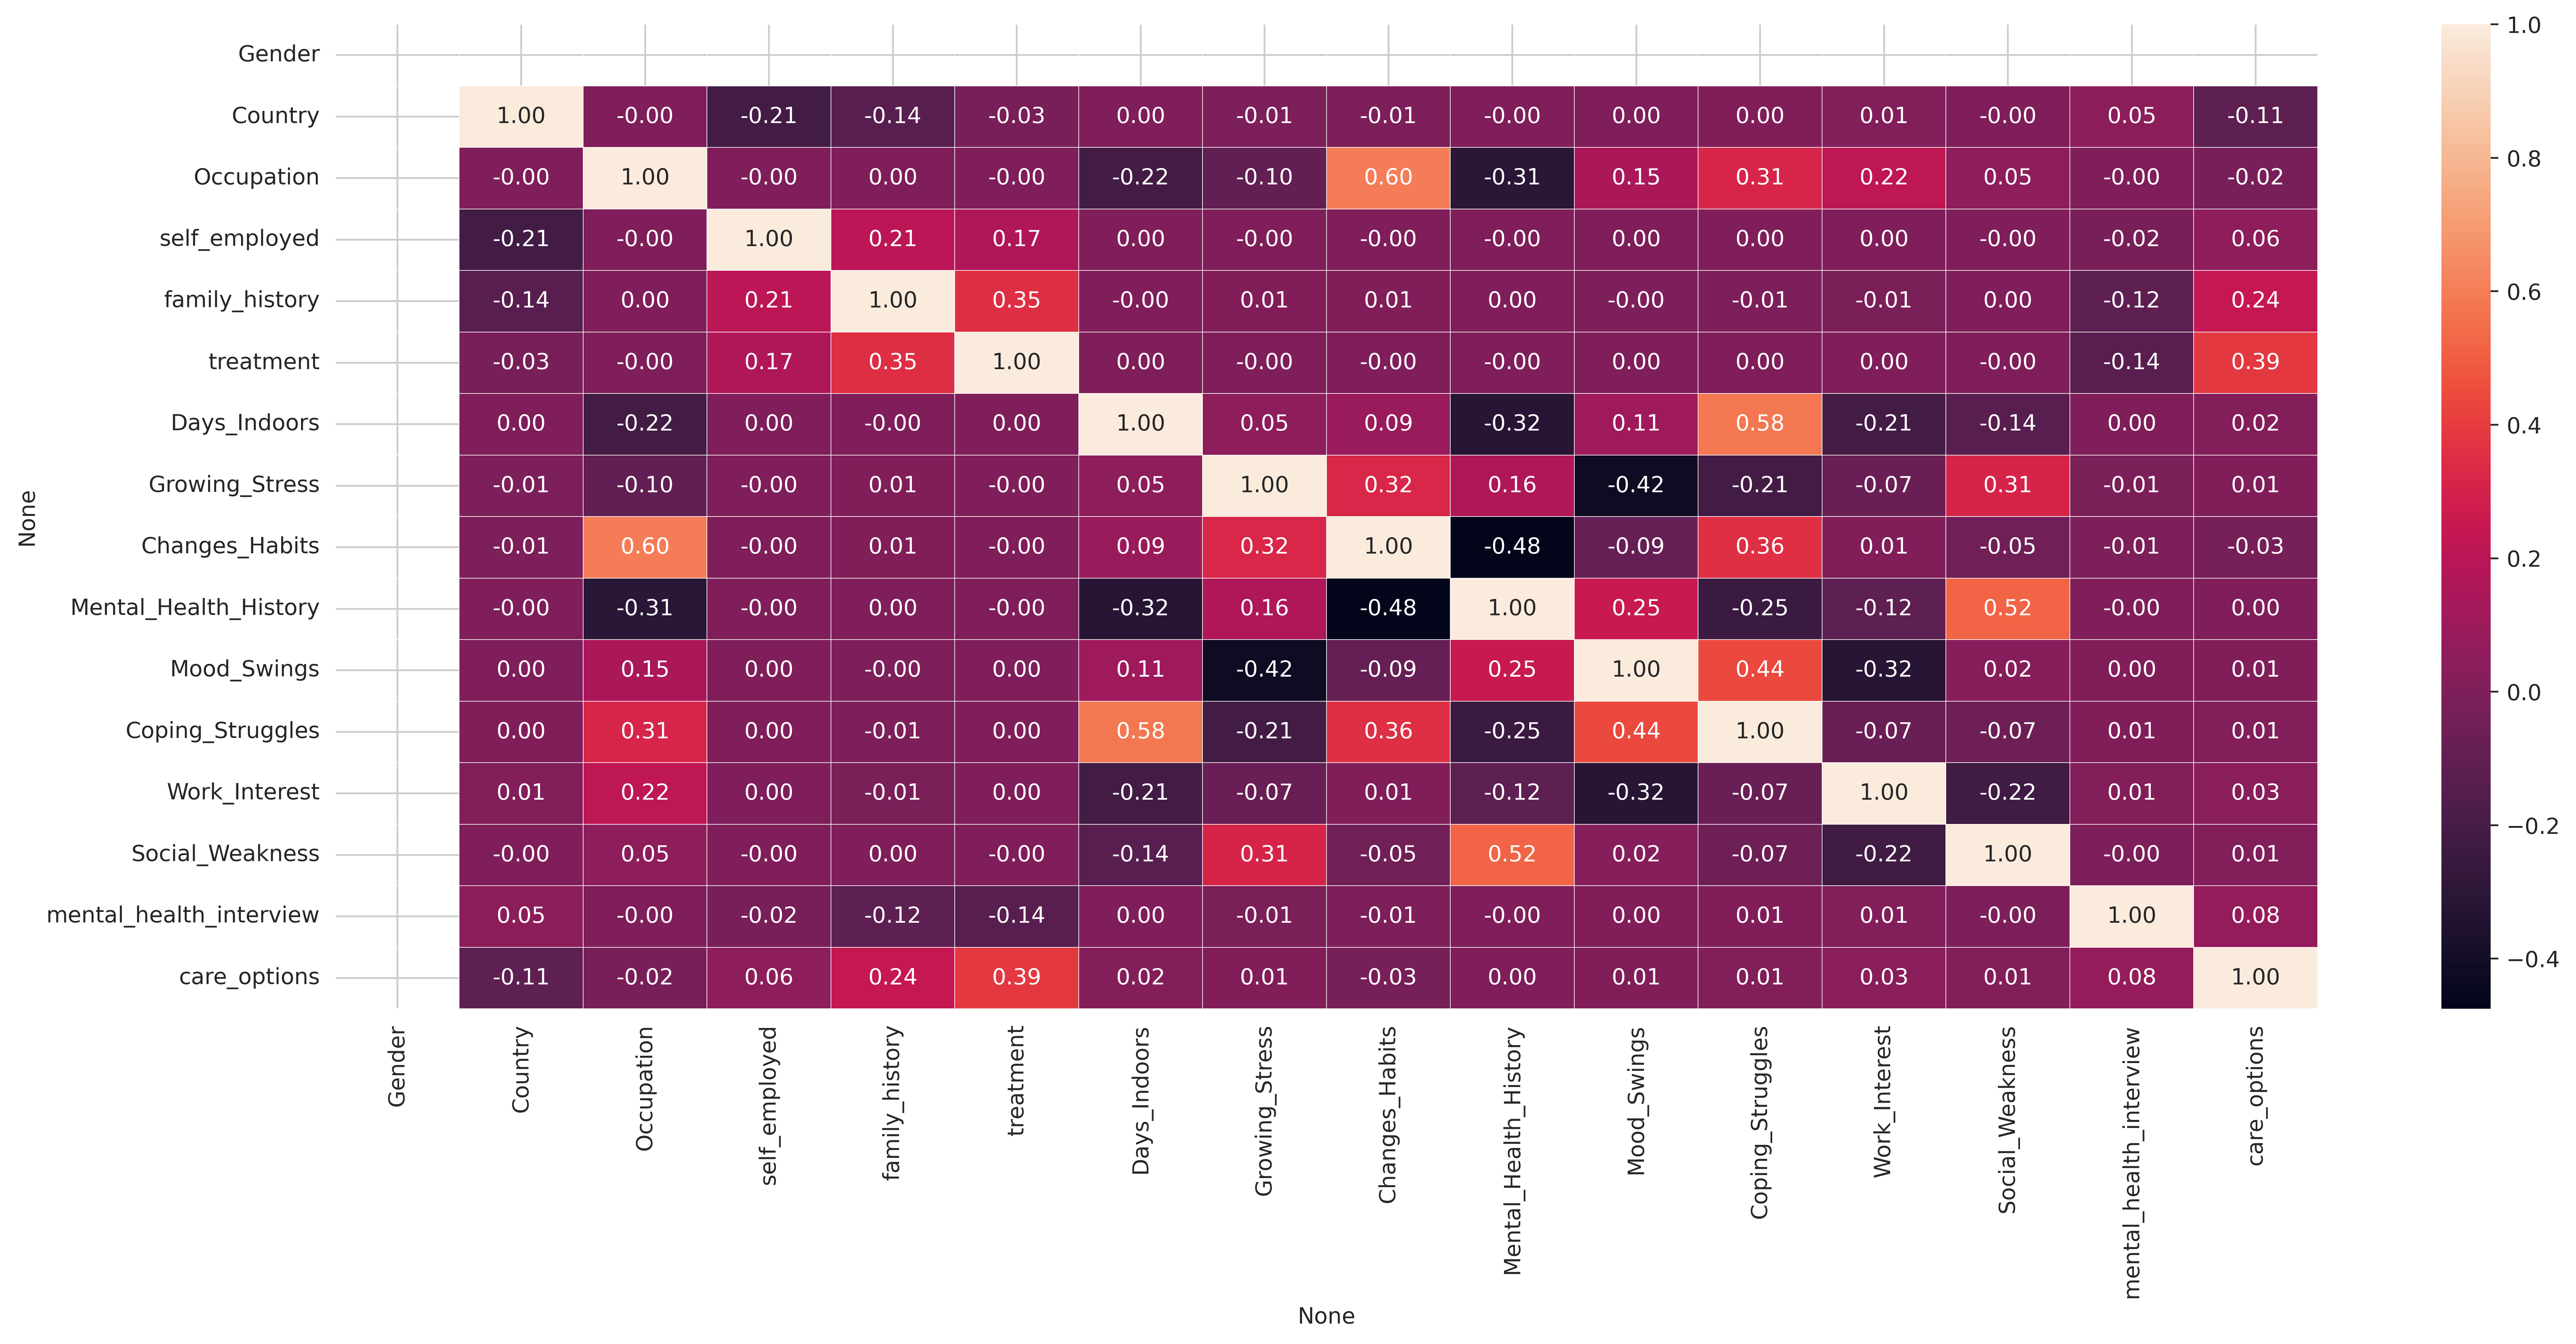

In [152]:
# @title ####**Correlation heatmap**
##Using correlation plot to see if we can remove some columns to avoid overfitting
plt.figure(figsize=(20,8), dpi =500)
corr = imputed_data.corr(method = 'pearson')
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.01)
plt.show()
##the features didnt have any correlations

### **Train and test spliting**

In [153]:

from sklearn.model_selection import train_test_split
X = imputed_data.drop(['care_options'],axis=1)
y = imputed_data['care_options']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42,shuffle=True)
y_train = y_train.astype(bool)


<ipython-input-153-b8d098eb1488>:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = imputed_data.drop(['care_options'],axis=1)


### **SVC algorithm**

In [154]:

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score

#Build the model
svm = SVC(kernel="rbf", gamma=0.5, C=10.0)
# Trained the model
params = {'gamma': [0,0.01,0.05,0.1,0.2,0.4,1], 'C': [1,3,10,100]}
grid_search_cv = GridSearchCV(svm, params, cv=5)
svm.fit(X_train,y_train.values.ravel())
svm_train=svm.predict(X_train)
svm_test=svm.predict(X_test)


In [155]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train.values.ravel(),svm_train))
print(accuracy_score(y_test.values.ravel(),svm_test))


0.8057620817843866
0.6777777777777778


In [156]:
# @title defining scores for diffrent gammas
gamma_values = np.arange(0, 1, 0.1)
k_folds = KFold(n_splits=10)
scores = [cross_val_score(svm.set_params(gamma=gamma_value),
                          X_train,
                          y_train.values.ravel(),
                          cv=k_folds
                         ) for gamma_value in gamma_values]

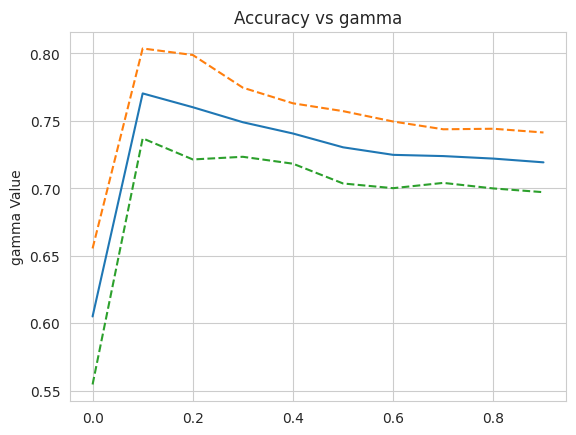

In [157]:
# @gamma vs accuracy
means = np.array([np.mean(score) for score in scores])
deviations = np.array([np.std(score) for score in scores])
sns.set_style("whitegrid")
figure = plt.figure()
axe = figure.gca()
line = plt.plot(gamma_values, means, axes=axe)
line = plt.plot(gamma_values, means + deviations, '--')
line = plt.plot(gamma_values, means - deviations, '--')
title = axe.set_title("Accuracy vs gamma")
label = axe.set_ylabel("Accuracy")
labels = axe.set_ylabel("gamma Value")


### **Decision Tree**

In [158]:
# @title best model
##defining best model with gridsearch
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score
clf = tree.DecisionTreeClassifier(max_depth=5,max_leaf_nodes=2,criterion='gini')
params = {'max_depth': list(range(1, 4)), 'max_leaf_nodes': [2,3,4],'criterion':['gini','entropy','log_loss']}
grid_search_cv = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), params, verbose=0, cv=5,)
grid_search_cv.fit(X_train ,y_train)
treepred_train=grid_search_cv.predict(X_train)
treepred_test=grid_search_cv.predict(X_test)

print("accuracy of train:%f" %accuracy_score(y_train,treepred_train))
print("accuracy of test:%f" %accuracy_score(y_test,treepred_test))
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test, treepred_test,average="weighted")
print('Precision test: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(y_test, treepred_test,average="weighted")
print('Recall test: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test, treepred_test,average="weighted")
print('F1 score test: %f' % f1)
print(grid_search_cv.best_params_)

accuracy of train:0.750929
accuracy of test:0.707407
Precision test: 0.724972
Recall test: 0.707407
F1 score test: 0.675268
{'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 4}


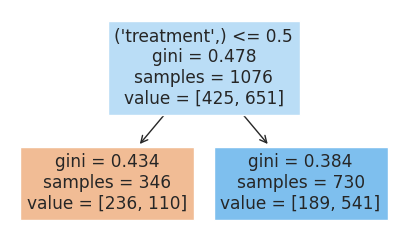

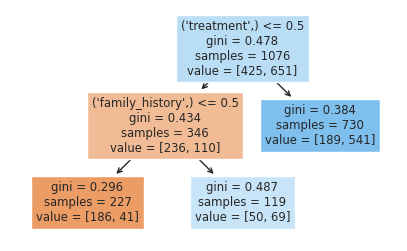

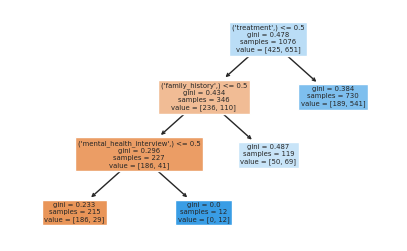

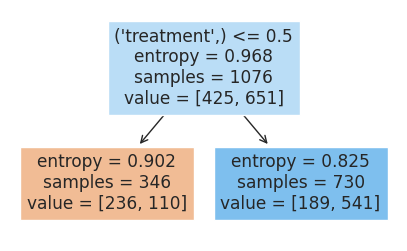

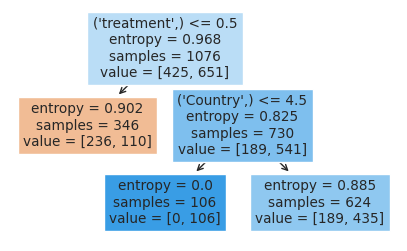

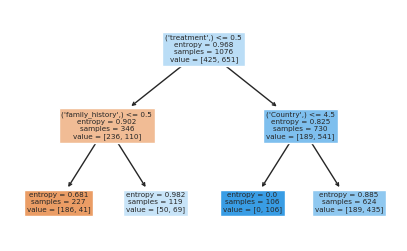

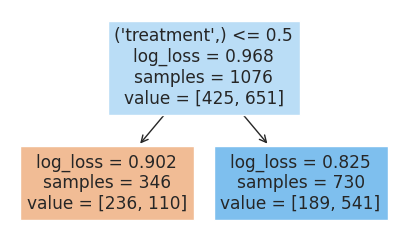

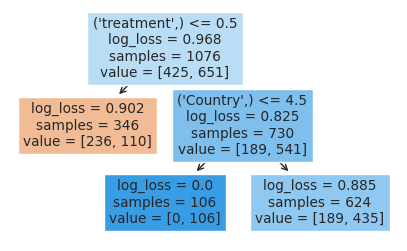

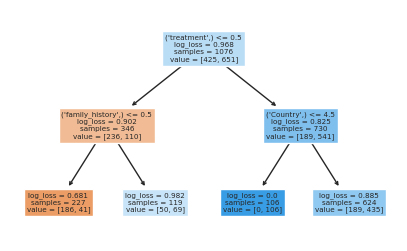

In [159]:
# @title diagrams of decisiontrees for diffrent criterias max params
##diffrent plots for diffrent criterias and max depths and max leafs
criterias=['gini','entropy','log_loss']
trainlist=[]
testlist=[]
name_gini=["gini and depth and leaf=2","gini and depth and leaf=3","gini and depth and leaf=4"]
for criteria in criterias:
  for i in range(2,5):
    clf = tree.DecisionTreeClassifier(max_depth=i,max_leaf_nodes=i,criterion=criteria)
    clf.fit(X_train ,y_train)
    treepred_train=clf.predict(X_train)
    treepred_test=clf.predict(X_test)
    fig = plt.figure(figsize=(5,3))
    tree.plot_tree(clf,
                   feature_names=X.columns, label='all',
                   filled=True)
    accuracy_train=accuracy_score(y_train,treepred_train)
    trainlist.append(accuracy_train)
    accuracy_test=accuracy_score(y_test,treepred_test)
    testlist.append(accuracy_test)




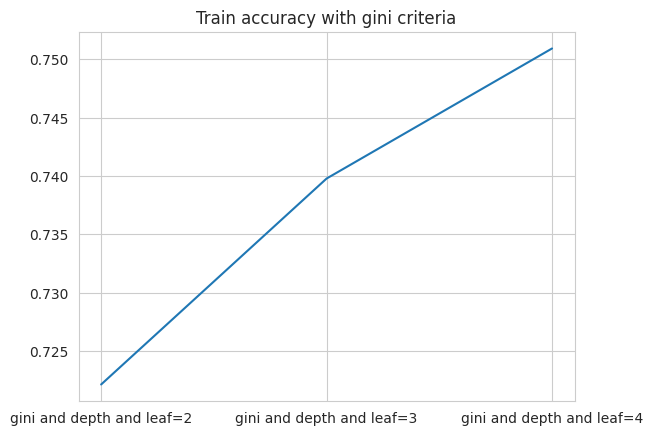

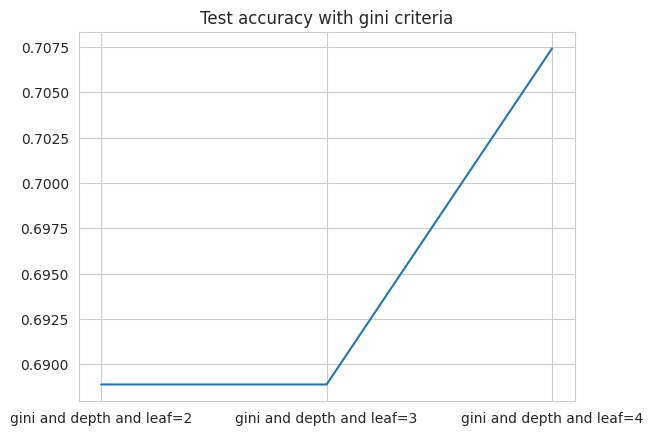

In [126]:
# @title Train and test accuracies for gini and 2 to 4 params
plt.plot(name_gini, trainlist[0:3])
plt.title('Train accuracy with gini criteria')
plt.show()
plt.plot(name_gini, testlist[3:6])
plt.title('Test accuracy with gini criteria')
plt.show()

Cross Validation Scores:  0.7286223370317922


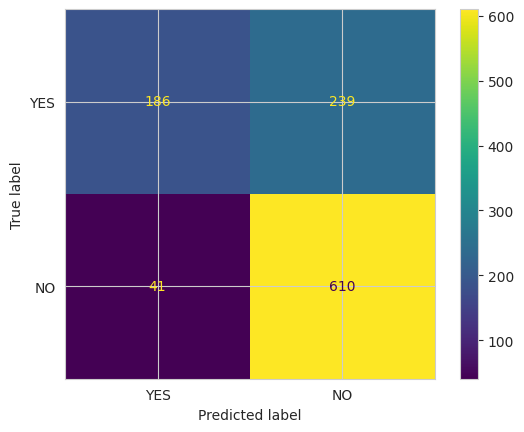

In [130]:
# @title Confusion Matrix
scores = cross_val_score(clf, X_train, y_train, cv =3,scoring="accuracy")
print("Cross Validation Scores: ", scores.mean())


confusion_matrix = metrics.confusion_matrix(y_train, treepred_train)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix ,display_labels=['YES','NO'])

cm_display.plot()
plt.show()

### **Shap plot**

In [169]:

import shap
explainer=shap.Explainer(clf.predict,X_train)
explainer_values=explainer(X_test)

PermutationExplainer explainer: 271it [00:45,  5.20it/s]                         


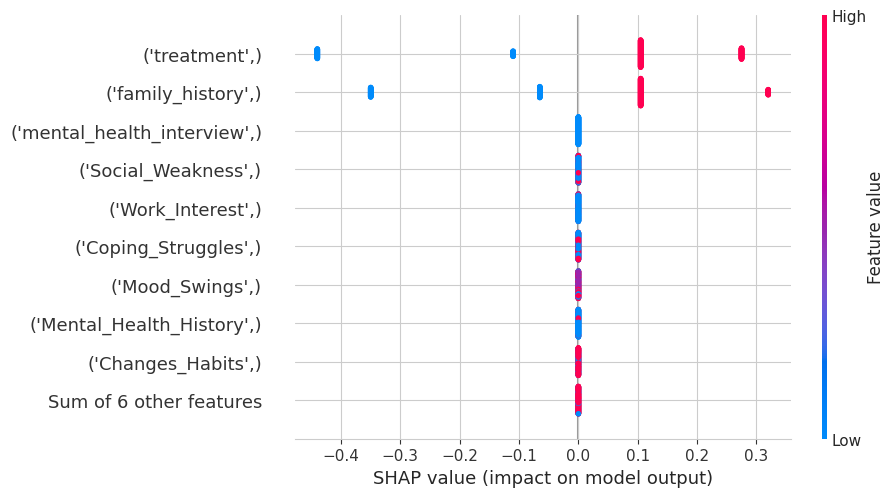

In [172]:
##shap plots

shap.plots.beeswarm(explainer_values)